In [1]:
#creating the attention neural network
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv('complete_dataset.csv')

In [3]:
X = dataset.drop(['Country','Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Total Disasters', 'Wildfire'], axis=1)
Y = dataset[['Total Disasters']].astype(np.float32)

In [4]:
# Scale the features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Scale the target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(Y)

In [30]:
# Function to create sequences by country
def create_sequences_by_country(X, y, n_steps, data):
    Xs, ys = [], []
    countries = data['Country'].unique()
    for country in countries:
        country_indices = data[data['Country'] == country].index
        country_data_X = X[country_indices]
        country_data_y = y[country_indices]
        for i in range(len(country_data_X) - n_steps):
            Xs.append(country_data_X[i:(i + n_steps)])
            ys.append(country_data_y[i + n_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

n_steps = 1  # Using 3 years of data to predict the next year
X_seq, y_seq = create_sequences_by_country(X_scaled, y_scaled, n_steps, dataset)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

In [31]:
print(y_train.shape)

(607, 1)


In [32]:
'''
This is the one I am currently working on
'''
def attnnk(head, dim, unit, shape):
    
    '''query = tf.keras.layers.Input(shape =(shape[1], shape[2]))
    key = tf.keras.layers.Input(shape =(shape[1], shape[2]))
    value =  tf.keras.layers.Input(shape =(shape[1], shape[2]))'''
    #the reason why it was expecting 3 inputs is because i created 3 inputs
    inp = tf.keras.layers.Input(shape = (shape[1], shape[2]))
    print(inp.shape)
    
    lstm = tf.keras.layers.LSTM(unit, return_sequences = True)(inp)
    
    #this allows for them to exist without needing 3 inputs
    query = tf.keras.layers.Lambda(lambda x: x, name = 'query')(inp)
    key = tf.keras.layers.Lambda(lambda x: x, name = 'key')(inp)
    value = tf.keras.layers.Lambda(lambda x: x, name = 'value')(inp)
    
    attention = tf.keras.layers.MultiHeadAttention(num_heads = head, key_dim = dim, value_dim = dim)(query = query, key = key,value = value)
    
    #attention = tf.keras.layers.Flatten()(attention)
    
    attlstm = tf.keras.layers.Concatenate()([lstm, attention])
    
    drop = tf.keras.layers.Dropout(.1)(attlstm)
    dense = tf.keras.layers.Dense(units = unit, activation = 'ReLU')(drop)
    dense2 = tf.keras.layers.Dense(units = unit, activation = 'ReLU')(dense)
    dense3 = tf.keras.layers.Dense(units = unit, activation = 'ReLU')(dense2)
    output = tf.keras.layers.Dense(units = 1, activation = 'softplus')(dense3)
    
    model = tf.keras.Model(inputs = inp, outputs = output)
    output = tf.squeeze(output)
    print(output.shape)
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['Accuracy', 'AUC', 'MeanSquaredError'])
    
    return model

In [33]:
epochs = 125
batch = 30
model = attnnk(31,64,21, X_train.shape)
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch, verbose = 2)
att_pred = model.predict(X_test)
print(att_pred.shape)

(None, 1, 22)
<unknown>
Epoch 1/125
21/21 - 3s - loss: 0.1112 - Accuracy: 0.0362 - auc: 0.5166 - mean_squared_error: 0.1112 - 3s/epoch - 161ms/step
Epoch 2/125
21/21 - 0s - loss: 0.0469 - Accuracy: 0.0445 - auc: 0.6600 - mean_squared_error: 0.0469 - 158ms/epoch - 8ms/step
Epoch 3/125
21/21 - 0s - loss: 0.0259 - Accuracy: 0.0461 - auc: 0.7064 - mean_squared_error: 0.0259 - 155ms/epoch - 7ms/step
Epoch 4/125
21/21 - 0s - loss: 0.0203 - Accuracy: 0.0461 - auc: 0.6969 - mean_squared_error: 0.0203 - 154ms/epoch - 7ms/step
Epoch 5/125
21/21 - 0s - loss: 0.0188 - Accuracy: 0.0461 - auc: 0.6945 - mean_squared_error: 0.0188 - 153ms/epoch - 7ms/step
Epoch 6/125
21/21 - 0s - loss: 0.0177 - Accuracy: 0.0461 - auc: 0.7090 - mean_squared_error: 0.0177 - 152ms/epoch - 7ms/step
Epoch 7/125
21/21 - 0s - loss: 0.0178 - Accuracy: 0.0461 - auc: 0.7034 - mean_squared_error: 0.0178 - 156ms/epoch - 7ms/step
Epoch 8/125
21/21 - 0s - loss: 0.0179 - Accuracy: 0.0445 - auc: 0.7076 - mean_squared_error: 0.0179 - 

In [34]:
'''
X_train = X_train.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
model = attnnk(31, 32, 31, X_train.shape)
X_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
X_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
X_train = X_train.batch(batch)
X_test = X_test.batch(batch)
#model = attnnk(31, 64, 31, X_train.shape)
history = model.fit(X_train, epochs=epoch)
results = model.evaluate(X_test)'''

'\nX_train = X_train.values\nX_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])\nX_test = X_test.values\nX_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])\nmodel = attnnk(31, 32, 31, X_train.shape)\nX_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))\nX_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))\nX_train = X_train.batch(batch)\nX_test = X_test.batch(batch)\n#model = attnnk(31, 64, 31, X_train.shape)\nhistory = model.fit(X_train, epochs=epoch)\nresults = model.evaluate(X_test)'

In [35]:
model2 = keras.models.Sequential([keras.layers.SimpleRNN(125, activation = 'relu'), keras.layers.Dense(1)])
model2.compile(optimizer = 'adam', loss = 'mse', metrics = ['Accuracy', 'AUC', 'MeanSquaredError'])
history2 = model2.fit(X_train, y_train, epochs=125, validation_split=0.3, verbose=2)

Epoch 1/125
14/14 - 2s - loss: 0.0660 - Accuracy: 0.0401 - auc: 0.6238 - mean_squared_error: 0.0660 - val_loss: 0.0317 - val_Accuracy: 0.0546 - val_auc: 0.4491 - val_mean_squared_error: 0.0317 - 2s/epoch - 115ms/step
Epoch 2/125
14/14 - 0s - loss: 0.0312 - Accuracy: 0.0425 - auc: 0.6898 - mean_squared_error: 0.0312 - val_loss: 0.0170 - val_Accuracy: 0.0546 - val_auc: 0.5520 - val_mean_squared_error: 0.0170 - 89ms/epoch - 6ms/step
Epoch 3/125
14/14 - 0s - loss: 0.0233 - Accuracy: 0.0425 - auc: 0.8084 - mean_squared_error: 0.0233 - val_loss: 0.0139 - val_Accuracy: 0.0546 - val_auc: 0.5277 - val_mean_squared_error: 0.0139 - 89ms/epoch - 6ms/step
Epoch 4/125
14/14 - 0s - loss: 0.0220 - Accuracy: 0.0425 - auc: 0.8026 - mean_squared_error: 0.0220 - val_loss: 0.0128 - val_Accuracy: 0.0546 - val_auc: 0.6020 - val_mean_squared_error: 0.0128 - 88ms/epoch - 6ms/step
Epoch 5/125
14/14 - 0s - loss: 0.0193 - Accuracy: 0.0425 - auc: 0.8104 - mean_squared_error: 0.0193 - val_loss: 0.0124 - val_Accurac

In [36]:
pred = model2.predict(X_test)
print(pred.shape)
att_pred = tf.squeeze(att_pred).numpy().reshape(-1,1)
att_pred = scaler_y.inverse_transform(att_pred)
pred = scaler_y.inverse_transform(pred)

y_test = scaler_y.inverse_transform(y_test)
attn_mse = tf.keras.metrics.mean_squared_error(y_test, att_pred)
rnn_mse = tf.keras.metrics.mean_squared_error(y_test, pred)
attn_mae = tf.keras.metrics.mean_absolute_error(y_test, att_pred)
rnn_mae = tf.keras.metrics.mean_absolute_error(y_test, pred)
print('att mse: ',attn_mse)
print('rnn mse: ',rnn_mse)
print('att mae: ',attn_mae)
print('rnn mae: ',rnn_mae)

9/9 [==============================] - 0s 2ms/step
(261, 1)
att mse:  tf.Tensor(
[2.07593203e+00 4.57889128e+00 1.97031176e+00 2.44923875e-01
 1.12105570e+01 7.53781712e-03 1.11520023e+01 6.00769577e+01
 1.29498219e+00 9.82125282e-01 4.41579151e+00 5.94482136e+00
 4.73064957e+01 1.13875437e+00 1.61452293e+01 1.02059436e+00
 4.57117033e+00 4.47254229e+00 2.37499380e+00 8.39725077e-01
 6.00676632e+00 5.38426816e-01 1.06657763e+01 2.40232992e+00
 1.47590673e+00 7.26054859e+00 1.48322268e+01 1.32567060e+00
 6.40037060e-02 3.74572165e-02 1.50335608e+01 2.65936685e+00
 6.45188451e-01 6.93057022e+01 2.93917847e+01 6.48236135e-04
 1.19523180e-03 5.72814703e-01 3.15068965e-03 7.17093408e-01
 3.06453481e-02 1.77785044e-03 3.52345419e+00 1.01261079e+00
 3.69565749e+00 4.44066277e+01 8.57938156e-02 1.09071708e+00
 6.81104898e-01 4.57794037e+01 2.06615734e+00 4.32542534e+01
 3.37852631e+01 5.28612137e+00 1.45718110e+00 4.24128580e+00
 7.77359056e+00 3.33306198e+01 3.20225573e+00 4.85272765e-01
 1.5

In [39]:
amse = attn_mse.numpy().sum()
amae = attn_mae.numpy().sum()
rmse = rnn_mse.numpy().sum()
rmae = rnn_mae.numpy().sum()
print(amse/261)
print(amae/261)
print(rmse/261)
print(rmae/261)

13.606744642001916
2.3935668477610155
15.205629078364463
2.5811309229825192


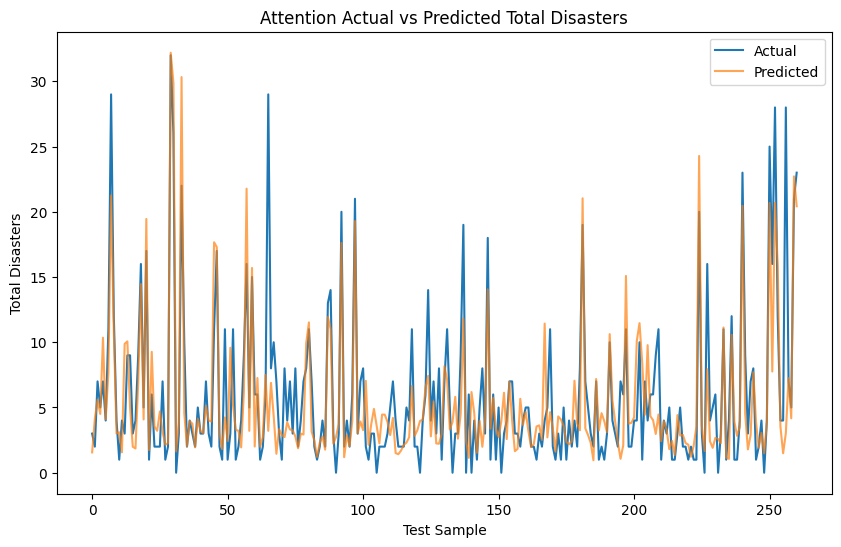

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(att_pred, label='Predicted', alpha=0.7)
plt.title('Attention Actual vs Predicted Total Disasters')
plt.xlabel('Test Sample')
plt.ylabel('Total Disasters')
plt.legend()
plt.show()
plt.savefig('att_predvsactual.png')

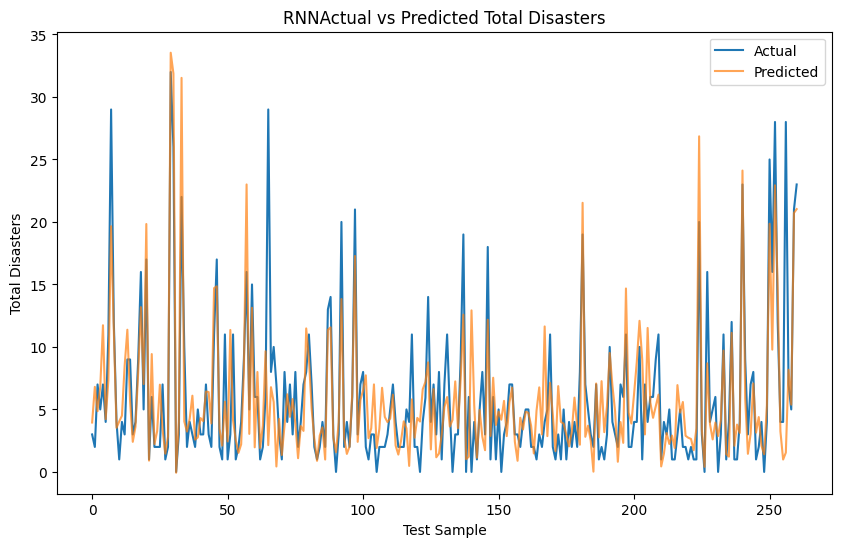

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predicted', alpha=0.7)
plt.title('RNNActual vs Predicted Total Disasters')
plt.xlabel('Test Sample')
plt.ylabel('Total Disasters')
plt.legend()
plt.show()
plt.savefig('rnn_predvsactual.png')

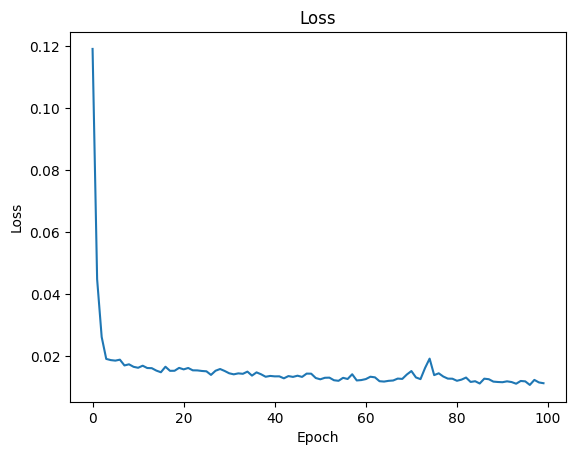

In [39]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


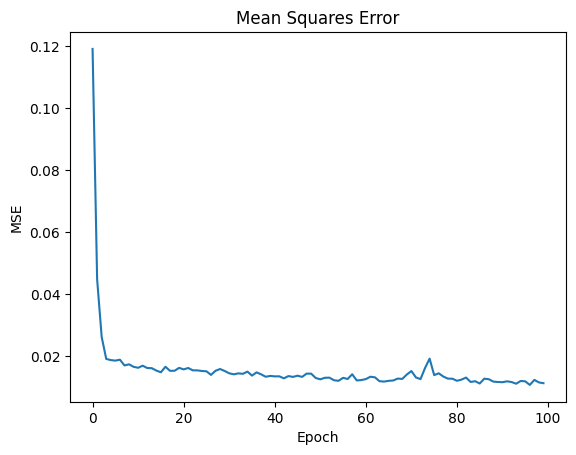

In [40]:
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Squares Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()